# Introduction

In this notebook, we will create a dataset of points on a uniform distribution and use a neural network to predict a function of those points. Specifically, each data point will be $(x_1, x_2)$ with the corresponding target of $f(x_1, x_2) = x_1^2 + x_1x_2 + x_2^2$. Let's begin with necessary imports.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split, DataLoader
from torch.utils.data.dataset import Subset
from torch.optim import Adam
from torch.distributions.uniform import Uniform
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from mpl_toolkits.mplot3d.axes3d import Axes3D
from time import time
from tqdm import tqdm

# Creating our Dataset

Our dataset will have $5000$ 2-dimensional points drawn from a uniform distribution on $[-10, 10] \times [-10, 10]$. $10\%$ of this data will be taken as testing, and the rest will be taken as training. We will also be using a batch size of $256$ and shuffle our train set for stochasticity in training. We don't need to shuffle our test set as we will always evaluate over the entire test set at once.

In [2]:
dataset_size: int = [5000, 2]
uniform_bounds: list[int] = [-10, 10]
X: torch.Tensor = Uniform(*uniform_bounds).sample(dataset_size)
Y: torch.Tensor = X[:, 0] ** 2 + X[:, 0] * X[:, 1] + X[:, 1] ** 2

Let's first take a look at our dataset.

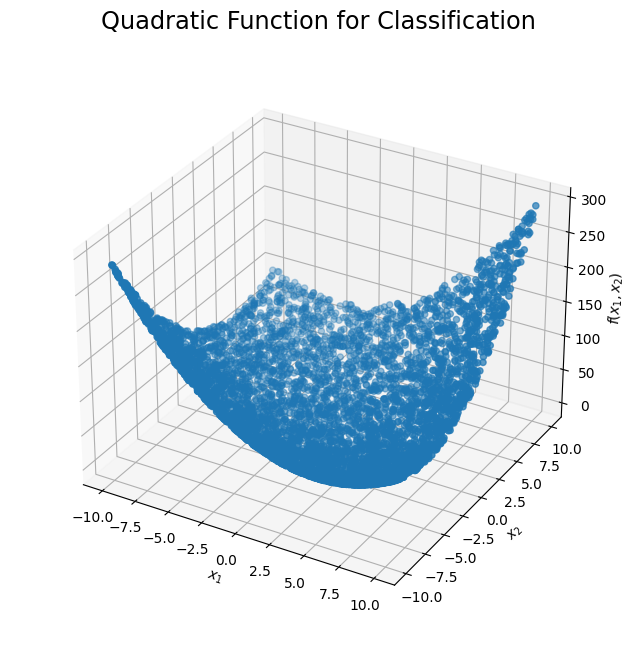

In [3]:
fig: Figure = plt.figure(figsize=(8, 8))
ax: Axes3D = fig.add_subplot(projection='3d')
ax.scatter(X[:, 0], X[:, 1], Y)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f(x_1, x_2)$')
ax.set_box_aspect(None, zoom=0.9)
ax.set_title('Quadratic Function for Classification', size='xx-large')
plt.autoscale()
plt.show()

Now let's put it into `DataLoader`s.

In [4]:
dataset: TensorDataset = TensorDataset(X, Y)
split_size: int = int(len(dataset) * 0.1)
train_set: Subset; test_set: Subset
train_set, test_set = random_split(
    dataset,
    [
        len(dataset) - split_size,
        split_size
    ]
)

In [5]:
train_dataloader: DataLoader = DataLoader(
    train_set,
    batch_size=256,
    shuffle=True
)
test_dataloader: DataLoader = DataLoader(
    test_set,
    batch_size=256,
    shuffle=False
)

# Building the Model

Now let's build our model. Our model will take in a two-dimensional input, have hidden layers with $16 \rightarrow 64 \rightarrow 8$ neurons, all with ReLU activations, and output a single value. The model will have a learning rate of $0.001$ and will train for 100 epochs using the ``torch.optim.Adam`` optimizer. The loss function will be ``torch.nn.MSELoss``, which, for a single training example $(x, y)$, is defined as $$\mathcal{L}(\theta) = (y - f(x;\theta))^2$$
where $f$ is our model, parameterized by $\theta$.

In [6]:
class NN_Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1: nn.Linear = nn.Linear(2, 16)
        self.linear2: nn.Linear = nn.Linear(16, 64)
        self.linear3: nn.Linear = nn.Linear(64, 8)
        self.linear4: nn.Linear = nn.Linear(8, 1)
        self.relu: nn.ReLU = nn.ReLU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        return x

In [7]:
lr: float = 0.001
epochs: int = 100

model: NN_Regressor = NN_Regressor().cuda()
loss: nn.MSELoss = nn.MSELoss()
optimizer: Adam = Adam(model.parameters(), lr=lr)

Let's take a look at our model.

In [8]:
model

NN_Regressor(
  (linear1): Linear(in_features=2, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=8, bias=True)
  (linear4): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

# Training the Model

Now let's train the model. Every batch, we will record the train and test loss. At the end of every epoch, we will also print out the average train loss over all batches in that epoch as well as the test loss and time elapsed.

In [9]:
metrics: list[str] = ['Train Loss', 'Test Loss']
history: pd.DataFrame = pd.DataFrame(columns=metrics)

for epoch in range(epochs):
    train_loss: float = 0.0
    test_loss: float = 0.0
    start_time: float = time()
    x: torch.Tensor; y: torch.Tensor
    print(f'Epoch {epoch + 1}')
    for _, (x, y) in enumerate(tqdm(train_dataloader)):
        x = x.cuda()
        y = y.unsqueeze(1).cuda()
        optimizer.zero_grad()
        y_pred: torch.Tensor = model(x)
        fit: torch.Tensor = loss(y_pred, y)
        fit.backward()
        optimizer.step()
        batch_train_loss = fit.item()
        train_loss += batch_train_loss
        for _, (x, y) in enumerate(test_dataloader):
            with torch.no_grad():
                x = x.cuda()
                y = y.unsqueeze(1).cuda()
                y_pred = model(x)
                fit = loss(y_pred, y)
                test_loss += fit.item()
        test_loss /= len(test_dataloader)
        history.loc[len(history)] = [batch_train_loss, test_loss]
    time_elapsed: float = time() - start_time
    print(f'Epoch Average Train Loss: {train_loss}')
    print(f'Test Loss: {test_loss}')
    print(f'Time Elapsed: {time_elapsed:.2f}s')

Epoch 1


100%|██████████| 18/18 [00:00<00:00, 36.48it/s]


Epoch Average Train Loss: 132056.50390625
Test Loss: 14768.760174326599
Time Elapsed: 0.50s
Epoch 2


100%|██████████| 18/18 [00:00<00:00, 75.14it/s]


Epoch Average Train Loss: 129753.6826171875
Test Loss: 14462.570290714502
Time Elapsed: 0.24s
Epoch 3


100%|██████████| 18/18 [00:00<00:00, 76.24it/s]


Epoch Average Train Loss: 126252.541015625
Test Loss: 13866.446188163012
Time Elapsed: 0.24s
Epoch 4


100%|██████████| 18/18 [00:00<00:00, 79.74it/s]


Epoch Average Train Loss: 118136.4345703125
Test Loss: 12664.440285131335
Time Elapsed: 0.23s
Epoch 5


100%|██████████| 18/18 [00:00<00:00, 45.79it/s]


Epoch Average Train Loss: 103011.36962890625
Test Loss: 10523.863989718258
Time Elapsed: 0.40s
Epoch 6


100%|██████████| 18/18 [00:00<00:00, 63.72it/s]


Epoch Average Train Loss: 79799.29541015625
Test Loss: 7403.909214172512
Time Elapsed: 0.29s
Epoch 7


100%|██████████| 18/18 [00:00<00:00, 62.00it/s]


Epoch Average Train Loss: 50188.343994140625
Test Loss: 4028.634747781791
Time Elapsed: 0.30s
Epoch 8


100%|██████████| 18/18 [00:00<00:00, 62.63it/s]


Epoch Average Train Loss: 25629.426879882812
Test Loss: 1975.3043159558438
Time Elapsed: 0.29s
Epoch 9


100%|██████████| 18/18 [00:00<00:00, 49.35it/s]


Epoch Average Train Loss: 15744.803405761719
Test Loss: 1469.3265638486482
Time Elapsed: 0.37s
Epoch 10


100%|██████████| 18/18 [00:00<00:00, 55.97it/s]


Epoch Average Train Loss: 13294.396057128906
Test Loss: 1260.2919722760562
Time Elapsed: 0.33s
Epoch 11


100%|██████████| 18/18 [00:00<00:00, 73.72it/s]


Epoch Average Train Loss: 11542.849792480469
Test Loss: 1121.9616032640915
Time Elapsed: 0.25s
Epoch 12


100%|██████████| 18/18 [00:00<00:00, 75.47it/s]


Epoch Average Train Loss: 10465.233154296875
Test Loss: 1029.3320953906514
Time Elapsed: 0.24s
Epoch 13


100%|██████████| 18/18 [00:00<00:00, 72.28it/s]


Epoch Average Train Loss: 9725.540832519531
Test Loss: 962.9072666511638
Time Elapsed: 0.25s
Epoch 14


100%|██████████| 18/18 [00:00<00:00, 80.88it/s]


Epoch Average Train Loss: 9186.783782958984
Test Loss: 913.0649223960936
Time Elapsed: 0.23s
Epoch 15


100%|██████████| 18/18 [00:00<00:00, 78.59it/s]


Epoch Average Train Loss: 8845.282318115234
Test Loss: 877.8418074852088
Time Elapsed: 0.23s
Epoch 16


100%|██████████| 18/18 [00:00<00:00, 77.19it/s]


Epoch Average Train Loss: 8533.533721923828
Test Loss: 847.9537134679267
Time Elapsed: 0.24s
Epoch 17


100%|██████████| 18/18 [00:00<00:00, 78.09it/s]


Epoch Average Train Loss: 8206.152221679688
Test Loss: 824.926797340624
Time Elapsed: 0.23s
Epoch 18


100%|██████████| 18/18 [00:00<00:00, 78.93it/s]


Epoch Average Train Loss: 8031.520843505859
Test Loss: 802.7522164335242
Time Elapsed: 0.23s
Epoch 19


100%|██████████| 18/18 [00:00<00:00, 81.43it/s]


Epoch Average Train Loss: 7831.036956787109
Test Loss: 784.365128778154
Time Elapsed: 0.22s
Epoch 20


100%|██████████| 18/18 [00:00<00:00, 64.16it/s]


Epoch Average Train Loss: 7612.557342529297
Test Loss: 767.8181281689322
Time Elapsed: 0.28s
Epoch 21


100%|██████████| 18/18 [00:00<00:00, 74.34it/s]


Epoch Average Train Loss: 7416.301483154297
Test Loss: 751.1384927886538
Time Elapsed: 0.24s
Epoch 22


100%|██████████| 18/18 [00:00<00:00, 74.21it/s]


Epoch Average Train Loss: 7291.351989746094
Test Loss: 737.5695426759776
Time Elapsed: 0.25s
Epoch 23


100%|██████████| 18/18 [00:00<00:00, 76.08it/s]


Epoch Average Train Loss: 7135.728057861328
Test Loss: 721.9558489437914
Time Elapsed: 0.24s
Epoch 24


100%|██████████| 18/18 [00:00<00:00, 73.62it/s]


Epoch Average Train Loss: 7019.660583496094
Test Loss: 706.3805344548309
Time Elapsed: 0.25s
Epoch 25


100%|██████████| 18/18 [00:00<00:00, 73.56it/s]


Epoch Average Train Loss: 6822.6414794921875
Test Loss: 691.7452345535858
Time Elapsed: 0.25s
Epoch 26


100%|██████████| 18/18 [00:00<00:00, 69.44it/s]


Epoch Average Train Loss: 6688.027770996094
Test Loss: 675.5030087565538
Time Elapsed: 0.26s
Epoch 27


100%|██████████| 18/18 [00:00<00:00, 74.54it/s]


Epoch Average Train Loss: 6548.095275878906
Test Loss: 662.0346092935652
Time Elapsed: 0.25s
Epoch 28


100%|██████████| 18/18 [00:00<00:00, 55.29it/s]


Epoch Average Train Loss: 6424.8927001953125
Test Loss: 644.9486404632917
Time Elapsed: 0.33s
Epoch 29


100%|██████████| 18/18 [00:00<00:00, 73.76it/s]


Epoch Average Train Loss: 6230.1463623046875
Test Loss: 631.0198367818957
Time Elapsed: 0.25s
Epoch 30


100%|██████████| 18/18 [00:00<00:00, 70.97it/s]


Epoch Average Train Loss: 6065.197998046875
Test Loss: 615.0447507319041
Time Elapsed: 0.26s
Epoch 31


100%|██████████| 18/18 [00:00<00:00, 64.50it/s]


Epoch Average Train Loss: 5949.891540527344
Test Loss: 599.8085335224168
Time Elapsed: 0.28s
Epoch 32


100%|██████████| 18/18 [00:00<00:00, 50.77it/s]


Epoch Average Train Loss: 5797.594390869141
Test Loss: 584.6110367114889
Time Elapsed: 0.36s
Epoch 33


100%|██████████| 18/18 [00:00<00:00, 53.60it/s]


Epoch Average Train Loss: 5638.591323852539
Test Loss: 568.2616358285304
Time Elapsed: 0.34s
Epoch 34


100%|██████████| 18/18 [00:00<00:00, 50.17it/s]


Epoch Average Train Loss: 5503.634658813477
Test Loss: 554.1941151475767
Time Elapsed: 0.36s
Epoch 35


100%|██████████| 18/18 [00:00<00:00, 51.41it/s]


Epoch Average Train Loss: 5368.412292480469
Test Loss: 536.9142066342756
Time Elapsed: 0.35s
Epoch 36


100%|██████████| 18/18 [00:00<00:00, 54.87it/s]


Epoch Average Train Loss: 5181.567306518555
Test Loss: 521.0201489941683
Time Elapsed: 0.33s
Epoch 37


100%|██████████| 18/18 [00:00<00:00, 62.81it/s]


Epoch Average Train Loss: 5001.348098754883
Test Loss: 504.8828569789184
Time Elapsed: 0.29s
Epoch 38


100%|██████████| 18/18 [00:00<00:00, 68.95it/s]


Epoch Average Train Loss: 4807.515365600586
Test Loss: 486.67724034172716
Time Elapsed: 0.26s
Epoch 39


100%|██████████| 18/18 [00:00<00:00, 43.65it/s]


Epoch Average Train Loss: 4663.978591918945
Test Loss: 468.9933343894663
Time Elapsed: 0.42s
Epoch 40


100%|██████████| 18/18 [00:00<00:00, 65.13it/s]


Epoch Average Train Loss: 4559.58512878418
Test Loss: 451.7347616244806
Time Elapsed: 0.28s
Epoch 41


100%|██████████| 18/18 [00:00<00:00, 66.15it/s]


Epoch Average Train Loss: 4335.591735839844
Test Loss: 434.51673274155473
Time Elapsed: 0.28s
Epoch 42


100%|██████████| 18/18 [00:00<00:00, 72.41it/s]


Epoch Average Train Loss: 4190.594940185547
Test Loss: 421.32879518863047
Time Elapsed: 0.25s
Epoch 43


100%|██████████| 18/18 [00:00<00:00, 73.46it/s]


Epoch Average Train Loss: 3991.007354736328
Test Loss: 400.67337802250404
Time Elapsed: 0.25s
Epoch 44


100%|██████████| 18/18 [00:00<00:00, 65.49it/s]


Epoch Average Train Loss: 3842.7752990722656
Test Loss: 385.189324379724
Time Elapsed: 0.28s
Epoch 45


100%|██████████| 18/18 [00:00<00:00, 64.03it/s]


Epoch Average Train Loss: 3662.786575317383
Test Loss: 369.098003787396
Time Elapsed: 0.28s
Epoch 46


100%|██████████| 18/18 [00:00<00:00, 81.44it/s]


Epoch Average Train Loss: 3549.839324951172
Test Loss: 351.56973160163034
Time Elapsed: 0.22s
Epoch 47


100%|██████████| 18/18 [00:00<00:00, 77.24it/s]


Epoch Average Train Loss: 3363.360336303711
Test Loss: 338.0478015138069
Time Elapsed: 0.24s
Epoch 48


100%|██████████| 18/18 [00:00<00:00, 78.78it/s]


Epoch Average Train Loss: 3204.2720947265625
Test Loss: 320.460393534624
Time Elapsed: 0.23s
Epoch 49


100%|██████████| 18/18 [00:00<00:00, 43.61it/s]


Epoch Average Train Loss: 3077.8840713500977
Test Loss: 306.5483520370326
Time Elapsed: 0.42s
Epoch 50


100%|██████████| 18/18 [00:00<00:00, 28.53it/s]


Epoch Average Train Loss: 2880.910903930664
Test Loss: 296.0687524234527
Time Elapsed: 0.64s
Epoch 51


100%|██████████| 18/18 [00:00<00:00, 47.98it/s]


Epoch Average Train Loss: 2734.5641479492188
Test Loss: 276.73769856634317
Time Elapsed: 0.38s
Epoch 52


100%|██████████| 18/18 [00:00<00:00, 64.57it/s]


Epoch Average Train Loss: 2604.7726821899414
Test Loss: 264.412112108781
Time Elapsed: 0.28s
Epoch 53


100%|██████████| 18/18 [00:00<00:00, 65.06it/s]


Epoch Average Train Loss: 2442.4451065063477
Test Loss: 251.9753185827285
Time Elapsed: 0.28s
Epoch 54


100%|██████████| 18/18 [00:00<00:00, 62.77it/s]


Epoch Average Train Loss: 2322.6071243286133
Test Loss: 238.68973974796245
Time Elapsed: 0.29s
Epoch 55


100%|██████████| 18/18 [00:00<00:00, 61.81it/s]


Epoch Average Train Loss: 2194.4921646118164
Test Loss: 232.21573006731342
Time Elapsed: 0.30s
Epoch 56


100%|██████████| 18/18 [00:00<00:00, 51.04it/s]


Epoch Average Train Loss: 2084.828094482422
Test Loss: 219.6999408987176
Time Elapsed: 0.36s
Epoch 57


100%|██████████| 18/18 [00:00<00:00, 53.14it/s]


Epoch Average Train Loss: 1977.8281555175781
Test Loss: 209.60186018241802
Time Elapsed: 0.34s
Epoch 58


100%|██████████| 18/18 [00:00<00:00, 49.18it/s]


Epoch Average Train Loss: 1837.1998443603516
Test Loss: 196.2552507725195
Time Elapsed: 0.37s
Epoch 59


100%|██████████| 18/18 [00:00<00:00, 60.77it/s]


Epoch Average Train Loss: 1747.846580505371
Test Loss: 184.34448349144077
Time Elapsed: 0.30s
Epoch 60


100%|██████████| 18/18 [00:00<00:00, 74.34it/s]


Epoch Average Train Loss: 1657.8784561157227
Test Loss: 178.4891203129373
Time Elapsed: 0.25s
Epoch 61


100%|██████████| 18/18 [00:00<00:00, 76.18it/s]


Epoch Average Train Loss: 1587.3877258300781
Test Loss: 170.9905582742358
Time Elapsed: 0.24s
Epoch 62


100%|██████████| 18/18 [00:00<00:00, 73.81it/s]


Epoch Average Train Loss: 1500.8492813110352
Test Loss: 161.20391552592628
Time Elapsed: 0.25s
Epoch 63


100%|██████████| 18/18 [00:00<00:00, 71.68it/s]


Epoch Average Train Loss: 1414.0163955688477
Test Loss: 154.6573420209461
Time Elapsed: 0.25s
Epoch 64


100%|██████████| 18/18 [00:00<00:00, 74.67it/s]


Epoch Average Train Loss: 1351.8771476745605
Test Loss: 147.30878973947256
Time Elapsed: 0.24s
Epoch 65


100%|██████████| 18/18 [00:00<00:00, 71.58it/s]


Epoch Average Train Loss: 1304.2643280029297
Test Loss: 141.04579786062823
Time Elapsed: 0.25s
Epoch 66


100%|██████████| 18/18 [00:00<00:00, 74.01it/s]


Epoch Average Train Loss: 1222.3289108276367
Test Loss: 134.6064255317906
Time Elapsed: 0.25s
Epoch 67


100%|██████████| 18/18 [00:00<00:00, 79.10it/s]


Epoch Average Train Loss: 1167.7500610351562
Test Loss: 128.45492736730375
Time Elapsed: 0.23s
Epoch 68


100%|██████████| 18/18 [00:00<00:00, 80.25it/s]


Epoch Average Train Loss: 1105.3173332214355
Test Loss: 125.66012157130172
Time Elapsed: 0.23s
Epoch 69


100%|██████████| 18/18 [00:00<00:00, 77.05it/s]


Epoch Average Train Loss: 1047.6498222351074
Test Loss: 116.14294350180717
Time Elapsed: 0.24s
Epoch 70


100%|██████████| 18/18 [00:00<00:00, 83.86it/s]


Epoch Average Train Loss: 1006.7451171875
Test Loss: 110.45604727219325
Time Elapsed: 0.22s
Epoch 71


100%|██████████| 18/18 [00:00<00:00, 76.63it/s]


Epoch Average Train Loss: 959.9267921447754
Test Loss: 105.57619399744726
Time Elapsed: 0.24s
Epoch 72


100%|██████████| 18/18 [00:00<00:00, 81.80it/s]


Epoch Average Train Loss: 897.719123840332
Test Loss: 99.93916187610012
Time Elapsed: 0.22s
Epoch 73


100%|██████████| 18/18 [00:00<00:00, 59.02it/s]


Epoch Average Train Loss: 840.8238563537598
Test Loss: 96.34245770910638
Time Elapsed: 0.31s
Epoch 74


100%|██████████| 18/18 [00:00<00:00, 81.14it/s]


Epoch Average Train Loss: 809.3267822265625
Test Loss: 90.29718045248592
Time Elapsed: 0.22s
Epoch 75


100%|██████████| 18/18 [00:00<00:00, 79.60it/s]


Epoch Average Train Loss: 754.8999862670898
Test Loss: 85.97414522756299
Time Elapsed: 0.23s
Epoch 76


100%|██████████| 18/18 [00:00<00:00, 81.62it/s]


Epoch Average Train Loss: 711.6509838104248
Test Loss: 78.32320491618884
Time Elapsed: 0.22s
Epoch 77


100%|██████████| 18/18 [00:00<00:00, 81.80it/s]


Epoch Average Train Loss: 667.749605178833
Test Loss: 74.1871523358277
Time Elapsed: 0.22s
Epoch 78


100%|██████████| 18/18 [00:00<00:00, 78.41it/s]


Epoch Average Train Loss: 622.1070728302002
Test Loss: 69.08513269975083
Time Elapsed: 0.23s
Epoch 79


100%|██████████| 18/18 [00:00<00:00, 58.50it/s]


Epoch Average Train Loss: 587.8598098754883
Test Loss: 64.5194731791562
Time Elapsed: 0.31s
Epoch 80


100%|██████████| 18/18 [00:00<00:00, 66.16it/s]


Epoch Average Train Loss: 572.3467884063721
Test Loss: 60.73342375417997
Time Elapsed: 0.28s
Epoch 81


100%|██████████| 18/18 [00:00<00:00, 65.14it/s]


Epoch Average Train Loss: 542.1457576751709
Test Loss: 59.177734727971256
Time Elapsed: 0.28s
Epoch 82


100%|██████████| 18/18 [00:00<00:00, 72.71it/s]


Epoch Average Train Loss: 481.5539970397949
Test Loss: 53.20706724276533
Time Elapsed: 0.25s
Epoch 83


100%|██████████| 18/18 [00:00<00:00, 67.93it/s]


Epoch Average Train Loss: 445.1086597442627
Test Loss: 50.20266853643261
Time Elapsed: 0.27s
Epoch 84


100%|██████████| 18/18 [00:00<00:00, 78.67it/s]


Epoch Average Train Loss: 424.5807113647461
Test Loss: 46.38599332150625
Time Elapsed: 0.23s
Epoch 85


100%|██████████| 18/18 [00:00<00:00, 75.62it/s]


Epoch Average Train Loss: 387.2112350463867
Test Loss: 44.000610714778304
Time Elapsed: 0.24s
Epoch 86


100%|██████████| 18/18 [00:00<00:00, 68.07it/s]


Epoch Average Train Loss: 369.70877170562744
Test Loss: 41.429294768975524
Time Elapsed: 0.27s
Epoch 87


100%|██████████| 18/18 [00:00<00:00, 68.14it/s]


Epoch Average Train Loss: 354.84014415740967
Test Loss: 40.45061549361708
Time Elapsed: 0.27s
Epoch 88


100%|██████████| 18/18 [00:00<00:00, 73.45it/s]


Epoch Average Train Loss: 334.20319747924805
Test Loss: 37.07892786091543
Time Elapsed: 0.25s
Epoch 89


100%|██████████| 18/18 [00:00<00:00, 59.49it/s]


Epoch Average Train Loss: 309.8267660140991
Test Loss: 34.485711901994364
Time Elapsed: 0.31s
Epoch 90


100%|██████████| 18/18 [00:00<00:00, 61.94it/s]


Epoch Average Train Loss: 295.2863817214966
Test Loss: 32.16781448270558
Time Elapsed: 0.30s
Epoch 91


100%|██████████| 18/18 [00:00<00:00, 61.80it/s]


Epoch Average Train Loss: 275.95423889160156
Test Loss: 30.42175822079298
Time Elapsed: 0.30s
Epoch 92


100%|██████████| 18/18 [00:00<00:00, 69.61it/s]


Epoch Average Train Loss: 256.52375984191895
Test Loss: 27.84582425998451
Time Elapsed: 0.26s
Epoch 93


100%|██████████| 18/18 [00:00<00:00, 72.39it/s]


Epoch Average Train Loss: 242.8151617050171
Test Loss: 26.231099450837064
Time Elapsed: 0.25s
Epoch 94


100%|██████████| 18/18 [00:00<00:00, 69.20it/s]


Epoch Average Train Loss: 234.47045707702637
Test Loss: 26.19301473993619
Time Elapsed: 0.26s
Epoch 95


100%|██████████| 18/18 [00:00<00:00, 53.07it/s]


Epoch Average Train Loss: 226.97669982910156
Test Loss: 23.67455011092534
Time Elapsed: 0.34s
Epoch 96


100%|██████████| 18/18 [00:00<00:00, 73.01it/s]


Epoch Average Train Loss: 208.23121643066406
Test Loss: 23.182579932741646
Time Elapsed: 0.25s
Epoch 97


100%|██████████| 18/18 [00:00<00:00, 77.92it/s]


Epoch Average Train Loss: 198.84984350204468
Test Loss: 21.509305737017712
Time Elapsed: 0.23s
Epoch 98


100%|██████████| 18/18 [00:00<00:00, 70.49it/s]


Epoch Average Train Loss: 180.73431158065796
Test Loss: 20.023598024999956
Time Elapsed: 0.26s
Epoch 99


100%|██████████| 18/18 [00:00<00:00, 64.24it/s]


Epoch Average Train Loss: 171.91087865829468
Test Loss: 17.534401356155286
Time Elapsed: 0.28s
Epoch 100


100%|██████████| 18/18 [00:00<00:00, 70.83it/s]

Epoch Average Train Loss: 152.01483392715454
Test Loss: 17.018588144275782
Time Elapsed: 0.26s


# Analyzing the Model

Let's plot the train and test loss curves.

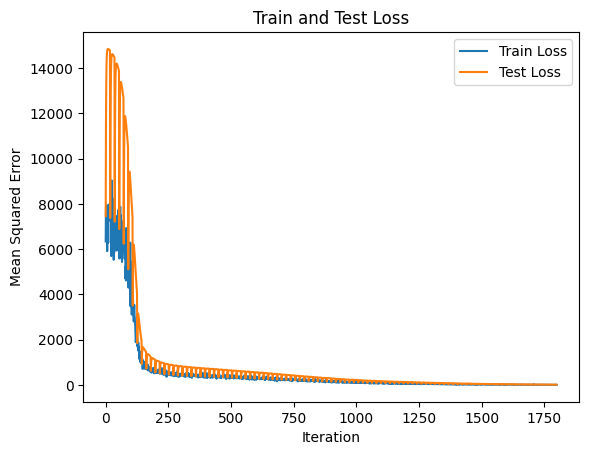

In [10]:
plt.plot(history.index, history['Train Loss'], label="Train Loss")
plt.plot(history.index, history['Test Loss'], label="Test Loss")
plt.title("Train and Test Loss")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error")
plt.show()

This plot definitely seems quite odd at first glance as the test loss is oscillating back and forth, but it actually makes quite a bit of sense on second thought. The key is that the test loss is the closest to the train loss at the start and end of every epoch. As epochs begin, the test loss shoots up, and as they end, the test loss comes back town towards the train loss. This happens because, every epoch, the model overfits to the first batch in the train set but gradually evens itself out as it sees the rest of the train set.

This effect is much more obvious at the start of training and gradually diminishes as training continues, which is also intuitive; at the start of the second epoch, the model has seen that first batch of data twice as much as the rest of the train set, so it makes sense that it would severely overfit to that data. On the fiftieth epoch, though, the model has only seen this first batch slightly more than the rest of the data, so the effect dwindles down.

Aside from this oscillation, though, both the train and test losses experience a steady descent together, indicating a good fit.

Now let's compute our final train and test losses.

In [11]:
def compute_loss(model: nn.Module, dataloader: DataLoader) -> float:
    """
    Computes the loss of the model over every training example in the DataLoader.

    Parameters:
        model:      The model to be evaluated over the DataLoader
        dataloader: The DataLoader over which the model is to be evaluated

    Returns:
        The loss value of the model over the dataloader
    """
    criterion: nn.MSELoss = nn.MSELoss()
    loss: float = 0
    x: torch.Tensor; y: torch.Tensor
    with torch.no_grad():
        for _, (x, y) in enumerate(tqdm(dataloader)):
            x = x.cuda()
            y = y.unsqueeze(1).cuda()
            optimizer.zero_grad()
            y_pred: torch.Tensor = model(x)
            fit: torch.Tensor = criterion(y_pred, y)
            loss += fit.item()                    
        return loss

In [12]:
train_loss: float = compute_loss(model, train_dataloader)
test_loss: float = compute_loss(model, test_dataloader)
print(f'Final Train Loss: {train_loss:.2f}, Final Test Loss: {test_loss:.2f}')

100%|██████████| 2/2 [00:00<00:00, 117.64it/s]

Final Train Loss: 154.33, Final Test Loss: 17.36


The train loss is much higher because there are $9$ times as many points in the data set. If we scale down the losses by the number of data points in the train and test sets, we get the following:

In [13]:
print(
    f'Scaled Train Loss: {train_loss / len(train_dataloader.dataset):.4f}, ',
    f'Scaled Test Loss: {test_loss / len(test_dataloader.dataset):.4f}'
)

Scaled Train Loss: 0.0343,  Scaled Test Loss: 0.0347


These are pretty reasonable loss values per data point, indicating a pretty low average deviation from the true function.